In [ ]:
import cv2
import os
import torch
import torch.utils
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
from contextlib import contextmanager
from timeit import default_timer
from test import *  # FIXME: better name
import numpy as np
import scipy.io
from scipy.linalg import hadamard
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import time



In [ ]:
@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start


def run_omp(X, y, n_nonzero_coefs, precompute=True, tol=0.0, normalize=False, fit_intercept=False, alg='naive'):
    if not isinstance(X, torch.Tensor):
        X = torch.as_tensor(X)
        y = torch.as_tensor(y)

    if fit_intercept or normalize:
        X = X.clone()
        assert not isinstance(precompute, torch.Tensor), "If user pre-computes XTX they can also pre-normalize X" \
                                                         " as well, so normalize and fit_intercept must be set false."

    if fit_intercept:
        X = X - X.mean(0)
        y = y - y.mean(1)[:, None]

    # To keep a good condition number on X, especially with Cholesky compared to LU factorization,
    # we should probably always normalize it (OMP is invariant anyways)
    if normalize is True:
        normalize = (X * X).sum(0).sqrt()  # User can also just optionally supply pre-computed norms.
        X /= normalize[None, :]  # Save compute if already normalized!

    if precompute is True or alg == 'v0':
        precompute = X.T @ X

    # If n_nonzero_coefs is equal to M, one should just return lstsq
    if alg == 'naive':
        sets, solutions, lengths = omp_naive(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)
    elif alg == 'v0':
        sets, solutions, lengths = omp_v0(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)

    solutions = solutions.squeeze(-1)
    if normalize is not False:
        solutions /= normalize[sets]

    xests = y.new_zeros(y.shape[0], X.shape[1])
    if lengths is None:
        xests[torch.arange(y.shape[0], dtype=sets.dtype, device=sets.device)[:, None], sets] = solutions
    else:
        for i in range(y.shape[0]):
            xests[i, sets[i, :lengths[i]]] = solutions[i, :lengths[i]]

    return xests

def batch_mm(matrix, matrix_batch, return_contiguous=True):
    """
    :param matrix: Sparse or dense matrix, size (m, n).
    :param matrix_batch: Batched dense matrices, size (b, n, k).
    :return: The batched matrix-matrix product, size (m, n) x (b, n, k) = (b, m, k).
    """
    batch_size = matrix_batch.shape[0]
    # Stack the vector batch into columns. (b, n, k) -> (n, b, k) -> (n, b*k)
    vectors = matrix_batch.transpose([1, 0, 2]).reshape(matrix.shape[1], -1)

    # A matrix-matrix product is a batched matrix-vector product of the columns.
    # And then reverse the reshaping. (m, n) x (n, b*k) = (m, b*k) -> (m, b, k) -> (b, m, k).
    if return_contiguous:
        result = np.empty_like(matrix_batch, shape=(batch_size, matrix.shape[0], matrix_batch.shape[2]))
        np.matmul(matrix, vectors, out=result.transpose([1, 0, 2]).reshape(matrix.shape[0], -1))
    else:
        result = (matrix @ vectors).reshape(matrix.shape[0], batch_size, -1).transpose([1, 0, 2])

    return result


def innerp(x, y=None, out=None):
    if y is None:
        y = x
    if out is not None:
        out = out[:, None, None]  # Add space for two singleton dimensions.
    return torch.matmul(x[..., None, :], y[..., :, None], out=out)[..., 0, 0]

def cholesky_solve(ATA, ATy):
    if ATA.dtype == torch.half or ATy.dtype == torch.half:
        return ATy.to(torch.float).cholesky_solve(torch.cholesky(ATA.to(torch.float))).to(ATy.dtype)
    return ATy.cholesky_solve(torch.cholesky(ATA)).to(ATy.dtype)


def omp_naive(X, y, n_nonzero_coefs):
    XT = np.asfortranarray(X.T)
    y = np.ascontiguousarray(y.T)  # TODO: Maybe this is not the fastest way to do it
    r = y.copy()
    sets = np.zeros((n_nonzero_coefs, y.shape[0]), dtype=np.int32)

    ATs = np.empty_like(y, shape=(y.shape[0], n_nonzero_coefs, X.shape[0]))
    # Trade b*k^2+bk memory for much less compute time. (This has to be done anyways, since we are batching, otherwise one could just permute columns of X in-place, as in https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/linear_model/_omp.py#L28 )
    ATAs = np.empty_like(r, shape=(y.shape[0], n_nonzero_coefs, n_nonzero_coefs))
    ATAs[:] = np.identity(n_nonzero_coefs, dtype=ATAs.dtype)

    # ATAsPacked = ATAs[(b_indices,) + np.triu_indices(n_nonzero_coefs)].T.copy()
    tri_idx = np.tril_indices(n_nonzero_coefs)
    ATAsPacked = ATAs[:, tri_idx[0], tri_idx[1]].transpose([1, 0])
    ATys = np.zeros_like(r, shape=(y.shape[0], n_nonzero_coefs, 1))  # .transpose([1, 0, 2])
    xests = np.zeros_like(y, shape=(y.shape[0], X.shape[1]))
    innerp = lambda x, y=None, out=None: np.einsum('bi,bi->b', x, x if y is None else y, out=out)
    for k in range(n_nonzero_coefs):
        projections = batch_mm(XT, r[:, :, None]).squeeze(-1)
        sets[k, :] = get_max_projections_blas(projections)
        # We will now update the following:
        AT = ATs[:, :k + 1, :] # A.transpose([0, 2, 1])
        ATA = ATAs[:, :k + 1, :k + 1]
        ATy = ATys[:, :k + 1]

        # Update As with the new column we add.
        updateA = XT[sets[k, :], :]
        AT[:, k, :] = updateA
        # Update ATy
        innerp(updateA, y, out=ATy[:, k, 0])

        if True:
            # Update ATAsPacked
            packed_idx = k*(k-1)//2
            np.matmul(AT[:, :k+1, :], updateA[:, :, None], out=ATAsPacked[k + packed_idx:packed_idx+2*k+1, :].T[:, :, None])
            solutions = ATy.transpose([0, 2, 1]).copy().transpose([0, 2, 1])  # We need it in fortran order.
            ppsv(np.ascontiguousarray(ATAsPacked[:packed_idx+2*k+1, :].T), solutions)
        else:
            # Update ATAs
            np.matmul(AT[:, :k+1, :], updateA[:, :, None], out=ATA[:, k, :k+1, None])  # We could use the following to dynamically select order: ATA[:, k, :k].strides[-1], ATA[:, :k, k].strides[-1]
            ATA[:, :k, k] = ATA[:, k, :k]
            solutions = np.linalg.solve(ATA, ATy)

        r[:] = y - (AT.transpose([0, 2, 1]) @ solutions).squeeze(-1)

    else:
        xests[np.arange(r.shape[0], dtype=sets.dtype)[:, None], sets.transpose([1, 0])] = solutions.squeeze(-1)

    return xests


def omp_v0(X, y, XTX, n_nonzero_coefs=None, tol=None, inverse_cholesky=True):
    B = y.shape[0]
    normr2 = innerp(y)  # Norm squared of residual.
    projections = (X.transpose(1, 0) @ y[:, :, None]).squeeze(-1)
    sets = y.new_zeros(n_nonzero_coefs, B, dtype=torch.int64)

    if inverse_cholesky:
        F = torch.eye(n_nonzero_coefs, dtype=y.dtype, device=y.device).repeat(B, 1, 1)
        a_F = y.new_zeros(n_nonzero_coefs, B, 1)

    D_mybest = y.new_empty(B, n_nonzero_coefs, XTX.shape[0])
    temp_F_k_k = y.new_ones((B, 1))

    if tol:
        result_lengths = sets.new_zeros(y.shape[0])
        result_solutions = y.new_zeros((y.shape[0], n_nonzero_coefs, 1))
        finished_problems = sets.new_zeros(y.shape[0], dtype=torch.bool)

    for k in range(n_nonzero_coefs+bool(tol)):
        # STOPPING CRITERIA
        if tol:
            problems_done = normr2 <= tol
            if k == n_nonzero_coefs:
                problems_done[:] = True

            if problems_done.any():
                new_problems_done = problems_done & ~finished_problems
                finished_problems.logical_or_(problems_done)
                result_lengths[new_problems_done] = k
                if inverse_cholesky:
                    result_solutions[new_problems_done, :k] = F[new_problems_done, :k, :k].permute(0, 2, 1) @ a_F[:k, new_problems_done].permute(1, 0, 2)
                else:
                    assert False, "inverse_cholesky=False with tol != None is not handled"
                if problems_done.all():
                    return sets.t(), result_solutions, result_lengths

        sets[k] = projections.abs().argmax(1)
        # D_mybest[:, k, :] = XTX[gamma[k], :]  # Same line as below, but significantly slower. (prob. due to the intermediate array creation)
        torch.gather(XTX, 0, sets[k, :, None].expand(-1, XTX.shape[1]), out=D_mybest[:, k, :])
        if k:
            D_mybest_maxindices = D_mybest.permute(0, 2, 1)[torch.arange(D_mybest.shape[0], dtype=sets.dtype, device=sets.device), sets[k], :k]
            torch.rsqrt(1 - innerp(D_mybest_maxindices), out=temp_F_k_k[:, 0])  # torch.exp(-1/2 * torch.log1p(-inp), temp_F_k_k[:, 0])
            D_mybest_maxindices *= -temp_F_k_k  # minimal operations, exploit linearity
            D_mybest[:, k, :] *= temp_F_k_k
            D_mybest[:, k, :, None].baddbmm_(D_mybest[:, :k, :].permute(0, 2, 1), D_mybest_maxindices[:, :, None])


        temp_a_F = temp_F_k_k * torch.gather(projections, 1, sets[k, :, None])
        normr2 -= (temp_a_F * temp_a_F).squeeze(-1)
        projections -= temp_a_F * D_mybest[:, k, :]
        if inverse_cholesky:
            a_F[k] = temp_a_F
            if k:  # Could maybe a speedup from triangular mat mul kernel.
                torch.bmm(D_mybest_maxindices[:, None, :], F[:, :k, :], out=F[:, k, None, :])
                F[:, k, k] = temp_F_k_k[..., 0]
    else:
        if inverse_cholesky:
            solutions = F.permute(0, 2, 1) @ a_F.squeeze(-1).transpose(1, 0)[:, :, None]
        else:
            AT = X.T[sets.T]
            solutions = cholesky_solve(AT @ AT.permute(0, 2, 1), AT @ y.T[:, :, None])

    return sets.t(), solutions, None


Done Video


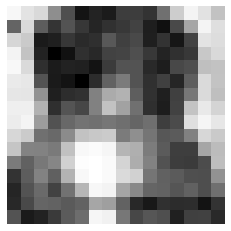

In [ ]:
if __name__ == "__main__":
    # TODO:

    #measurement
    #m_data = scipy.io.loadmat('measured_64.mat')
    #mdata = m_data['measurements_hh8_64']
    #dictionary
    m_dict = scipy.io.loadmat('/content/diccionarios16x16.mat')
    mdict = m_dict['M_frame']
    N1,N2,N3=mdict.shape

    mdict_x=np.reshape(mdict,(N3,N3))#NxN,NxN

    frame=scipy.io.loadmat('/content/dat16.mat')
    m_frame=frame['measurements_n_16']
    m_frame_1=np.zeros((1,N3))#1,NxN
    M,N=m_frame.shape
    tol =1e-3
    k = 0
    n_samples=N3 #NxN
    frames = []
    img_array = []
    fig = plt.figure()
    plt.axis('off')
    height, width=256,256
    #out1 = cv2.VideoWriter('output1.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, (width, height))

    #with elapsed_timer() as elapsed:

    mdata =m_frame
    n_components, n_features = N3, N3  #NxN,NxN

    n_nonzero_coefs = N3-len(np.where(mdata==0)[0])#NxN-
    y=mdata.T
    X=mdict_x.astype('float')
    X=X.T

    with elapsed_timer() as elapsed:
        xests_v0 = run_omp(torch.as_tensor(X.copy()), torch.as_tensor(y.copy()), n_nonzero_coefs-k, normalize=True, fit_intercept=False, tol=tol, alg='v0')
        xests_v0=np.abs(xests_v0)

    plt.axis('off')
    frames.append([plt.imshow(np.reshape(np.array(xests_v0),(N1,N2)), cmap=cm.Greys_r,animated=True)])
    plt.savefig('temp.png',bbox_inches='tight', pad_inches=0)

    print('Done Video')





